## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List, Type, Dict, Any
import matplotlib.pyplot as plt

### Data loading: "Евгений Онегин"


In [ ]:

!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2022-12-28 22:10:27--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2022-12-28 22:10:27 (8.23 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_new = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text_new))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {c: i for i, c in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {i: c for i, c in enumerate(tokens)}

In [ ]:
coded_text = np.array([token_to_idx[ch] for ch in text_new])

In [ ]:
len(tokens)

83

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
n_classes = 83
batch_size = 16
seq_length = 50
n_epochs = 30

train_data, val_data = coded_text[:len(coded_text) * 8 // 10], coded_text[len(coded_text) * 8 // 10:]

In [ ]:
class CharRNN_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers=1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.rnn = nn.RNN(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = torch.zeros(self.num_layers, x.size(0), self.n_hidden)
            
        x_ohe = self.emb(x)
        out, hid = self.rnn(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [ ]:
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr) // batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n + seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [ ]:
def train_model(net, train_data, val_data, criterion, 
                opt, lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau, lr_scheduler_params: Dict = {}):
    val_loss = []
    train_loss = []
    
    lr_scheduler = lr_scheduler_class(opt, **lr_scheduler_params)

    for epoch in range(n_epochs):
                
        ep_val_loss = []
        ep_train_loss = []

        net.train()
        for x, y in get_batches(train_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            net.zero_grad()
            output, hidden = net(inputs)

            loss = criterion(output, targets.long())
            loss.backward()
            
            ep_train_loss.append(loss.item())
            opt.step()
            
        net.eval()
        for x, y in get_batches(val_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            output, val_hidden = net(inputs)

            loss = criterion(output, targets.long()) 
            
            ep_val_loss.append(loss.item())
        
        lr_scheduler.step(loss.item())
        
        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  loss via training: {train_loss[-1]:.6f}")
        print(f"\t loss thru validation: {val_loss[-1]:.6f}")

    return train_loss, val_loss

In [ ]:
model_rnn = CharRNN_OHE(n_classes)
opt = torch.optim.Adam(model_rnn.parameters())
criterion = nn.CrossEntropyLoss()

train_loss, val_loss = train_model(model_rnn, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  loss via training: 3.430453
	 loss thru validation: 3.307596
Epoch 2 of 30
	  loss via training: 3.238436
	 loss thru validation: 3.106624
Epoch 3 of 30
	  loss via training: 3.002348
	 loss thru validation: 2.852048
Epoch 4 of 30
	  loss via training: 2.809530
	 loss thru validation: 2.688530
Epoch 5 of 30
	  loss via training: 2.697319
	 loss thru validation: 2.595668
Epoch 6 of 30
	  loss via training: 2.617420
	 loss thru validation: 2.532785
Epoch 7 of 30
	  loss via training: 2.557136
	 loss thru validation: 2.476710
Epoch 8 of 30
	  loss via training: 2.508449
	 loss thru validation: 2.432316
Epoch 9 of 30
	  loss via training: 2.465073
	 loss thru validation: 2.395545
Epoch 10 of 30
	  loss via training: 2.421984
	 loss thru validation: 2.356473
Epoch 11 of 30
	  loss via training: 2.398276
	 loss thru validation: 2.340079
Epoch 12 of 30
	  loss via training: 2.371717
	 loss thru validation: 2.312714
Epoch 13 of 30
	  loss via training: 2.347408
	 loss thru val

Plot the loss function (axis X: number of epochs, axis Y: loss function).

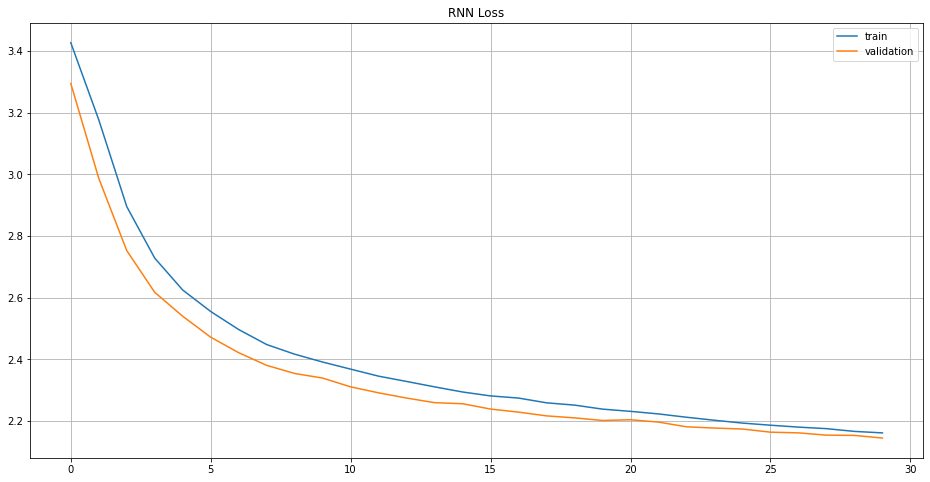

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('RNN Loss')
plt.ylabel = 'Value'
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.grid()
plt.legend(); 

In [ ]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=200, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
# An example of generated text.
print(generate_sample(model_rnn))

 приветсоды катилась…»
и премиенкавы, так залас слеил,
неприждального душал
оней, но не нужим, горнитвачая,
о мно знакиме семсен,
смола промноткму, едну на сврей
монные утыбя перастя;
дву с етцялся, п


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [ ]:
class CharLSTM_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers = 1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.lstm = nn.LSTM(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = (torch.zeros(self.num_layers, x.size(0), self.n_hidden), 
                   torch.zeros(self.num_layers, x.size(0), self.n_hidden))
            
        x_ohe = self.emb(x)
        out, hid = self.lstm(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [ ]:
model_lstm = CharLSTM_OHE(n_classes)
opt = torch.optim.Adam(model_lstm.parameters())
criterion = nn.CrossEntropyLoss()

train_loss_lstm, val_loss_lstm = train_model(model_lstm, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  loss via training: 3.458972
	 loss thru validation: 3.321141
Epoch 2 of 30
	  loss via training: 3.279797
	 loss thru validation: 3.191339
Epoch 3 of 30
	  loss via training: 3.104740
	 loss thru validation: 2.986651
Epoch 4 of 30
	  loss via training: 2.943297
	 loss thru validation: 2.846591
Epoch 5 of 30
	  loss via training: 2.837478
	 loss thru validation: 2.757275
Epoch 6 of 30
	  loss via training: 2.760851
	 loss thru validation: 2.693425
Epoch 7 of 30
	  loss via training: 2.712825
	 loss thru validation: 2.645303
Epoch 8 of 30
	  loss via training: 2.672044
	 loss thru validation: 2.612949
Epoch 9 of 30
	  loss via training: 2.638607
	 loss thru validation: 2.584100
Epoch 10 of 30
	  loss via training: 2.608607
	 loss thru validation: 2.548279
Epoch 11 of 30
	  loss via training: 2.581106
	 loss thru validation: 2.519643
Epoch 12 of 30
	  loss via training: 2.557273
	 loss thru validation: 2.498101
Epoch 13 of 30
	  loss via training: 2.535067
	 loss thru val

Plot the loss function of the number of epochs. Does the final loss become better?

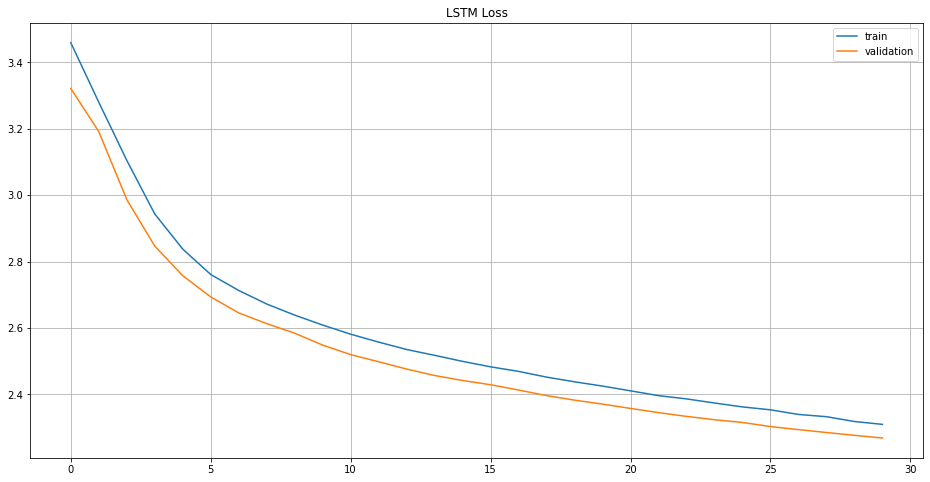

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('LSTM Loss')
plt.plot(train_loss_lstm, label='train')
plt.plot(val_loss_lstm, label='validation')
plt.grid()
plt.legend(); 

In [ ]:
print(generate_sample(model_lstm))

 привет,
что ражов касторескилней
и так м пицинно мила ь маро;
на ы да о росе азлет,
и волу слузьми. удал…
наздреетсенны-томолег;
пенит и вегриге ли не
дряна ка, долдне мечтриты,
мозця мня сто мольчит


**Сonclusion:** Final loss is not better than RNN loss.


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
for i in [0.001, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]:
    print("Temperature = ", i)
    print(generate_sample(model_lstm, temperature = i),'\n')

Temperature =  0.001
 приветь не сторо не стора
на сторо не сторо не стора
на сторо сторо не сторой
и сторо сторо не стора
и сторо сторо не сторой
и сторо сторо не стора
и сторо сторо не сторой
и сторо сторо не стора
и ст 

Temperature =  0.1
 приветь на сторой стора
не воден он сердце в сере
не постала с постоль оне
постоль не в сере постольный,
и стора с постоленье стора
не поровно в сере стара
не постоль не в сердце полена
не стори серд 

Temperature =  0.2
 приветил сене сторать,
и поле серди с болена
и молет он волена в сере
не полене веленный свое



xxxii

в тал пором он поренный стала
и в страве сторо в сере
не страсти не не в сере полени
меленный п 

Temperature =  0.5
 привет тарака,
порди слаские но товой,
не вете боленья он поро,
как той в таль не жам предит толи на селенье
и стамин порал дель нелья,
поролин с замовалья вот
таль в затда тат на ваденье
следней лен 

Temperature =  1.0
 привете ьсеньечвы расsыяшка.



xv

лененье зобрутить ила коджу:
ссерслан оза мол ов тарес

**Сonclusion:** 
- For high temperatures predicted probabilities become more random in contrans with low temperature iwhen they become more determrminant.
- Most comprehensible text is for temp = 0.5

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
torch.save(model_lstm, './lstm_model_pushkin.pth')

model_new = torch.load('./lstm_model_pushkin.pth')
print(generate_sample(model_new))

 привет…
сенди ссере сгосруж, не мерпых,
лавдо слечерный рвдикинь
ухатит кимые скоечта,
втепал, и флобоннел,
лазде дотся еглака
на сер блу в модь: коцедлить,
так нек гоолкю вестнам нанаят;
поо той зно


### References
1. Andrew Karpathy blog post about RNN.
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names. 2. Repo with char-rnn code 3. Cool repo with PyTorch examples: link